# Debugging models trained for Robocup

* Models trained on robocup dataset . Fusion accuracy is lower than single image accuracy 
* Goal is to identify why 
* Steps:
    - Load the model
    - Find an image with most error between fusion and single image
    - Analyze which pixels are contributing the most
    
* Results:
    - After removing intialization
    - with 5 batch size
    - 1D with evidetial loss + not increasing + maybe we require to give more epochs
    - 2D convolution with evidential + the confidence in summing up, performance is same 

In [1]:
import sys
sys.path.insert(1, '/home/deebuls/Documents/phd/blender-dataset/MultiViewEvidentialUncertaintyFusion')
import robocup_model
import vkitti_model
import metrics
import torch
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.callbacks import DeviceStatsMonitor,LearningRateMonitor,TQDMProgressBar
from pytorch_lightning.loggers import TensorBoardLogger

import matplotlib.pyplot as plt
import numpy as np

import pytorch_lightning as pl

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F

from sklearn.metrics import ConfusionMatrixDisplay
import segmentation_models_pytorch as smp
import torchmetrics
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts,CosineAnnealingLR

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from robocup_dataloader import RoboCupDataset
from robocup_dataloader import SequentialRobocupDataset
import vkitti_dataloader
import epipolar_geometry
import evidence_loss
import uncertain_fusion
import plot_prediction

from metrics import IoU, SegmentationMetric
from kornia import image_to_tensor, tensor_to_image
from kornia.augmentation import ColorJitter, RandomChannelShuffle, RandomThinPlateSpline
from kornia.augmentation import RandomVerticalFlip, RandomHorizontalFlip, RandomMotionBlur
from kornia.augmentation import RandomGaussianNoise, RandomSharpness, RandomCrop
from kornia.augmentation import RandomEqualize, RandomGaussianBlur


## Model 

In [2]:

class SequenceRobocupModel(pl.LightningModule):

    def __init__(self, model_path, train_dataset_path, valid_dataset_path, encoder_name, convolution_type, out_classes):
        super().__init__()

        self.save_hyperparameters()

        self.model_path = model_path
        self.model = torch.load(model_path)
        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        #Freezing the network
        self.model.eval()
        for param in self.model.parameters():
            param.requires_grad = False

        # preprocessing parameteres for image
        self.n_classes = out_classes
        self.train_dataset_path = train_dataset_path
        self.valid_dataset_path = valid_dataset_path
                        
        self.loss_fn = evidence_loss.edl_mse_loss
        self.convolution_type = convolution_type
        

        self.kornia_pre_transform = vkitti_dataloader.Preprocess() #per image convert to tensor
        
        #self.conv_1d = torch.nn.Conv2d(in_channels=2*self.n_classes, out_channels=self.n_classes, kernel_size=1)
        self.val_0_iou = IoU(n_classes=self.n_classes, reduction="micro-imagewise")
        self.val_1_iou = IoU(n_classes=self.n_classes, reduction="micro-imagewise")
        self.OneD_fusion_iou = IoU(n_classes=self.n_classes, reduction="micro-imagewise")
        
        self.val_0_seg_metric = SegmentationMetric(self.n_classes).cuda()
        self.val_1_seg_metric = SegmentationMetric(self.n_classes).cuda()
        self.OneD_fusion_seg_metric = SegmentationMetric(self.n_classes).cuda()
       
        self.confusion_matrix = torchmetrics.ConfusionMatrix(num_classes=self.n_classes, normalize='true')
       
        if convolution_type == '1D':
            self.conv_1d = torch.nn.Sequential(
                              #torch.nn.BatchNorm2d(2*self.n_classes),
                              torch.nn.Conv2d(in_channels=2*self.n_classes, 
                                           out_channels=self.n_classes, 
                                           kernel_size=1, 
                                           device=self.device),
                            )
        elif convolution_type == '2D':
            self.conv_1d = torch.nn.Sequential(
                              torch.nn.Conv2d(in_channels=2*self.n_classes, 
                                           out_channels=self.n_classes, 
                                           kernel_size=3, 
                                           device=self.device),
                             torch.nn.Upsample(size=(512,512), mode = 'nearest') #Make the image size auto
                            )
        else:
            raise 

        #for m in self.modules():
        #    if isinstance(m, torch.nn.Conv2d):
        #        if m is self.conv_1d:
        #            torch.nn.init.normal_(m.weight, mean=0.0, std=0.01)
    
    def forward(self, batch):
        #Freezing the network
        self.model.eval()
        for param in self.model.parameters():
            param.requires_grad = False

        # normalize image
        normalized_image = (batch["image0"] - self.mean) / self.std 
        logits_mask0 = self.model(normalized_image)
        
        propagate_mask0 = self.epipolar_propagation(logits_mask0, 
                                                     batch['depth0'],
                                                     batch['translation_0_to_1_camera_frame'],
                                                     batch['rotation_0_to_1_camera_frame'])
        
        
        # normalize image
        normalized_image = (batch["image1"] - self.mean) / self.std 
        logits_mask1 = self.model(normalized_image)
        
        fused_mask = torch.concat((propagate_mask0,logits_mask1), dim=1)
        fused_mask = self.conv_1d(fused_mask)

        
        logits_mask0 = F.relu(logits_mask0) + 1
        propagate_mask0 = F.relu(propagate_mask0) + 1
        logits_mask1 = F.relu(logits_mask1) + 1
        #fused_mask = F.relu(fused_mask) + 1
        
        return logits_mask0, propagate_mask0, logits_mask1, fused_mask
    
   
        
        
    def shared_step(self, batch, stage):
        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert batch["image0"].ndim == 4
        
        bs, num_channels, height, width = batch["image0"].size()

        # Check that image dimensions are divisible by 32, 
        assert height % 32 == 0 and width % 32 == 0

        # Shape of the mask should be [batch_size, num_classes, height, width]
        # for binary segmentation num_classes = 1
        assert batch["mask0"].ndim == 4
        assert batch["mask1"].ndim == 4
        
        logits_mask0, propagate_mask0, logits_mask1, fused_mask = self.forward(batch)
        
        fused_mask = fused_mask.permute(0,2,3,1)
        # [batch_size, height*width, n_classes] -> [batch_size*height*width, n_classes]
        fused_mask = fused_mask.reshape(-1, self.n_classes)
        mask = torch.ravel(batch["mask1"])
        # [batch_size*height*width] -> [batch_size*height*width, n_classes] 
        mask = F.one_hot(mask.to(torch.long), self.n_classes)
        #loss = self.loss_fn(fused_mask, mask, self.current_epoch, self.n_classes, 5)
        loss = F.cross_entropy(fused_mask, mask.argmax(dim=1).to(torch.long))
        self.log(f"{stage}/evidential_loss", loss, prog_bar=True)
        
        fused_mask = F.relu(fused_mask) + 1
        #confusion matrix calculation 
        self.confusion_matrix(fused_mask.argmax( dim=1, keepdim=True), mask.argmax( dim=1, keepdim=True))

        #Getting back to shape
        fused_mask = fused_mask.reshape(bs,  height, width, self.n_classes)
        fused_mask = fused_mask.permute(0,3,1,2)
        
        #Logging
        self.val_0_iou.update(logits_mask0.argmax( dim=1, keepdim=True), batch["mask0"])
        self.val_1_iou.update(logits_mask1.argmax( dim=1, keepdim=True), batch["mask1"])
        self.OneD_fusion_iou.update(fused_mask.argmax( dim=1, keepdim=True), batch["mask1"])

        self.val_0_seg_metric.addBatch(logits_mask0.argmax( dim=1, keepdim=True), batch["mask0"])
        self.val_1_seg_metric.addBatch(logits_mask1.argmax( dim=1, keepdim=True), batch["mask1"])
        self.OneD_fusion_seg_metric.addBatch(fused_mask.argmax( dim=1, keepdim=True), batch["mask1"])

        
        return loss
      

    def shared_epoch_end(self, outputs, stage):
        try :
            self.log(f"iou/{stage}/0_iou", self.val_0_iou.compute(), prog_bar=False)
            self.log(f"iou/{stage}/1_iou", self.val_1_iou.compute(), prog_bar=True)
            self.log(f"iou/{stage}/"+self.convolution_type, self.OneD_fusion_iou.compute(), prog_bar=True)
            self.log("FrequencyIoU/"+stage+"/0", 
                             self.val_0_seg_metric.Frequency_Weighted_Intersection_over_Union(), prog_bar=False)
            self.log("FrequencyIoU/"+stage+"/1", 
                             self.val_1_seg_metric.Frequency_Weighted_Intersection_over_Union(), prog_bar=True)
            #print ("Val 1 Class Pixel Accuracy :", self.val_1_seg_metric.classPixelAccuracy())
            #print ("Val 1 Mean Pixel Accuracy :", self.val_1_seg_metric.meanPixelAccuracy())
            #print ("Val 1 IoU Per class :", self.val_1_seg_metric.IntersectionOverUnion())
            self.log("FrequencyIoU/"+stage+"/"+self.convolution_type, 
                             self.OneD_fusion_seg_metric.Frequency_Weighted_Intersection_over_Union(), prog_bar=True)
            self.log("PixelAccuracy"+stage+"/"+self.convolution_type, 
                 self.OneD_fusion_seg_metric.pixelAccuracy(), prog_bar=False)
            self.log("MeanIoU/"+stage+"/"+self.convolution_type,
                 self.OneD_fusion_seg_metric.meanIntersectionOverUnion(), prog_bar=False)
            #print ("Class Pixel Accuracy "+self.convolution_type, self.OneD_fusion_seg_metric.classPixelAccuracy())
            #print ("Mean Pixel Accuracy "+self.convolution_type, self.OneD_fusion_seg_metric.meanPixelAccuracy())
            #print ("IoU Per class "+self.convolution_type, self.OneD_fusion_seg_metric.IntersectionOverUnion())
        except:
            print("Error in the iou compute or FrequencyIou")
        self.val_0_seg_metric.reset()
        self.val_1_seg_metric.reset()
        self.OneD_fusion_seg_metric.reset()
        self.val_0_iou.reset()
        self.val_1_iou.reset()
        self.OneD_fusion_iou.reset()


        # turn confusion matrix into a figure (Tensor cannot be logged as a scalar)
        fig, ax = plt.subplots(figsize=(20,20))
        disp = ConfusionMatrixDisplay(confusion_matrix=self.confusion_matrix.compute().cpu().numpy(),
                                      display_labels=self.label_names)
        disp.plot(ax=ax)
        # log figure
        self.logger.experiment.add_figure(stage+'/confmat'+self.convolution_type, fig, global_step=self.global_step)
        
        #np.save(CM_FILE_NAME, self.train_cm.compute().cpu().numpy())
    
        self.confusion_matrix.reset()
        return       

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")            

    def training_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx): 
        return self.shared_step(batch, "valid")

    def validation_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "valid")

    def test_step(self, batch, batch_idx):
        if batch_idx > 0:
            return
        bs, num_channels, height, width = batch["image0"].size()
        with torch.no_grad():
            self.model.eval()
            logits_mask0, propagate_mask0, logits_mask1, fused_mask = self.forward(batch)
            fused_mask = F.relu(fused_mask) +1
            uncertainty = self.n_classes / torch.sum(fused_mask, dim=1, keepdim=True)

            fig = plot_prediction.plot_sample( torch.argmax(logits_mask0, dim=1, keepdim=True),
                                               torch.argmax(propagate_mask0, dim=1, keepdim=True), 
                                               torch.argmax(logits_mask1, dim=1, keepdim=True),
                                               torch.argmax(fused_mask, dim=1, keepdim=True),   
                                               uncertainty,
                                               batch['mask1'],
                                               batch['image1']
                                             )
            self.logger.experiment.add_figure(f'test_'+self.convolution_type, fig, global_step=self.global_step)
            
        # log figure
        return
    def configure_optimizers(self):
        #optimizer=torch.optim.AdamW(filter(lambda p: p.requires_grad, self.parameters()), lr=0.0001, weight_decay=1e-5)
        optimizer=torch.optim.AdamW( self.conv_1d.parameters(), lr=1e-3, weight_decay=1e-5)
        #scheduler = CosineAnnealingLR(optimizer, T_max=self.trainer.max_epochs)
        scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-5, last_epoch=-1)
    
        return {'optimizer': optimizer,'lr_scheduler':scheduler}

    def train_dataloader(self):
        dataset = SequentialRobocupDataset(self.train_dataset_path, "two_sequence", transforms=self.kornia_pre_transform)
        loader = DataLoader(dataset, batch_size=5, shuffle=False, num_workers=10,
                            persistent_workers=True, pin_memory=True)
        self.label_names = dataset.label_names
        print ('training dataset length : ', len(dataset))
        self.epipolar_propagation = epipolar_geometry.EpipolarPropagation(dataset.K, 
                                   dataset.Kinv, 
                                   dataset.height, 
                                   dataset.width, 
                                   fill_empty_with_ones=True)
        self.epipolar_propagation.cuda()
        return loader

    def val_dataloader(self):
        dataset = SequentialRobocupDataset(self.valid_dataset_path, "two_sequence", transforms=self.kornia_pre_transform)
        loader = DataLoader(dataset, batch_size=5, shuffle=False, num_workers=10,
                            persistent_workers=True, pin_memory=True)
        self.label_names = dataset.label_names
        print ('Vaidation dataset length : ', len(dataset))
        self.epipolar_propagation = epipolar_geometry.EpipolarPropagation(dataset.K, 
                                   dataset.Kinv, 
                                   dataset.height, 
                                   dataset.width, 
                                   fill_empty_with_ones=True)
        self.epipolar_propagation.cuda()
        return loader

    def test_dataloader(self):
        dataset = SequentialRobocupDataset(self.valid_dataset_path, "two_sequence", transforms=self.kornia_pre_transform)
        loader = DataLoader(dataset, batch_size=5, shuffle=False, num_workers=10,
                            persistent_workers=True, pin_memory=True)
        self.label_names = dataset.label_names
        print ('Training dataset length : ', len(dataset))
        self.epipolar_propagation = epipolar_geometry.EpipolarPropagation(dataset.K, 
                                   dataset.Kinv, 
                                   dataset.height, 
                                   dataset.width, 
                                   fill_empty_with_ones=True)
        self.epipolar_propagation.cuda()
        return loader

---------------------------

## Training 

In [13]:
ARCH_NAME = 'FPN' 
OUT_CLASSES = 6
MODEL_PATH = './robocup_mobilenet.pt'
#MODEL_PATH = './robocup_resnet18.pt'
#MODEL_PATH = './robocup_efficientnet.pt'

ENCODER_NAME = 'timm-mobilenetv3_small_minimal_100'
#ENCODER_NAME = 'resnet18'
#ENCODER_NAME = 'efficientnet-b1'

TRAIN_DATASET_PATH = '/home/deebuls/Documents/phd/blender-dataset/learning_blenerproc/images_robocup/'
VAL_DATASET_PATH = '/home/deebuls/Documents/phd/blender-dataset/learning_blenerproc/images_pose_robocup/'

In [14]:
torch.__version__


'1.12.0'

In [15]:
sequence_1d_model = SequenceRobocupModel(model_path=MODEL_PATH,
                                                     train_dataset_path=TRAIN_DATASET_PATH,
                                                     valid_dataset_path=VAL_DATASET_PATH,
                                                     encoder_name=ENCODER_NAME,
                                                     convolution_type='2D',
                                                     out_classes=OUT_CLASSES)    
#device = 'cuda'
#sequence_1d_model = sequence_1d_model.to(device)


In [16]:
logger = TensorBoardLogger("lightning_logs", name="robocup")
trainer = pl.Trainer(
        accelerator='gpu', 
        #devices=1,
        max_epochs=20,
        callbacks=[LearningRateMonitor(logging_interval="step"), 
                   TQDMProgressBar(refresh_rate=1000)],
        check_val_every_n_epoch=10,
        logger=logger,
        enable_checkpointing=False,
        #overfit_batches=2000
    )

    
trainer.fit( sequence_1d_model) 
trainer.validate( sequence_1d_model ) 
#trainer.test(sequence_1d_model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type               | Params
--------------------------------------------------------------
0 | model                  | FPN                | 2.2 M 
1 | kornia_pre_transform   | Preprocess         | 0     
2 | val_0_iou              | IoU                | 0     
3 | val_1_iou              | IoU                | 0     
4 | OneD_fusion_iou        | IoU                | 0     
5 | val_0_seg_metric       | SegmentationMetric | 0     
6 | val_1_seg_metric       | SegmentationMetric | 0     
7 | OneD_fusion_seg_metric | SegmentationMetric | 0     
8 | confusion_matrix       | ConfusionMatrix    | 0     
9 | conv_1d                | Sequential         | 654   
--------------------------------------------------------------
654       Trainable params
2.2 M     Non-trainable params
2

Sanity Checking: 0it [00:00, ?it/s]

Found 150 files in the folder
Found 100 two image sequences 
filename  0000.hdf5
Vaidation dataset length :  100
cuda
Found 534 files in the folder
Found 356 two image sequences 
filename  330.hdf5
training dataset length :  356
cuda


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Error in the iou compute or FrequencyIou


Validation: 0it [00:00, ?it/s]

Error in the iou compute or FrequencyIou


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Found 150 files in the folder
Found 100 two image sequences 
filename  0000.hdf5
Vaidation dataset length :  100
cuda


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   FrequencyIoU/valid/0    │    0.9538748264312744     │
│   FrequencyIoU/valid/1    │    0.9498335719108582     │
│   FrequencyIoU/valid/2D   │     0.958168625831604     │
│     MeanIoU/valid/2D      │    0.7020430564880371     │
│   PixelAccuracyvalid/2D   │    0.9754787683486938     │
│      iou/valid/0_iou      │    0.9354298710823059     │
│      iou/valid/1_iou      │    0.9423983693122864     │
│       iou/valid/2D        │    0.9497698545455933     │
│   valid/evidential_loss   │    0.08920377492904663    │
└───────────────────────────┴───────────────────────────┘

[{'valid/evidential_loss': 0.08920377492904663,
  'iou/valid/0_iou': 0.9354298710823059,
  'iou/valid/1_iou': 0.9423983693122864,
  'iou/valid/2D': 0.9497698545455933,
  'FrequencyIoU/valid/0': 0.9538748264312744,
  'FrequencyIoU/valid/1': 0.9498335719108582,
  'FrequencyIoU/valid/2D': 0.958168625831604,
  'PixelAccuracyvalid/2D': 0.9754787683486938,
  'MeanIoU/valid/2D': 0.7020430564880371}]

In [6]:
seq_val_loader = sequence_1d_model.val_dataloader()
sequence_1d_model.epipolar_propagation

Found 150 files in the folder
Found 100 two image sequences 
filename  0000.hdf5
Vaidation dataset length :  100
cuda


EpipolarPropagation()

In [7]:
device = 'cuda'
sequence_1d_model = sequence_1d_model.to(device)
val_1_seg_metric = metrics.SegmentationMetric(6).cuda()
OneD_fusion_seg_metric = metrics.SegmentationMetric(6).cuda()


img_count = 0
for batch in seq_val_loader:
    print (batch.keys())
    device = 'cuda'
    batch['image1'] = batch['image1'].to(device)
    batch['image0'] = batch['image0'].to(device)
    batch['mask1'] = batch['mask1'].to(device)
    batch['mask0'] = batch['mask0'].to(device)
    print (batch['image0'].device, batch['image1'].device,
           batch['rotation_0_to_1_camera_frame'].device, batch['translation_0_to_1_camera_frame'].device)
    logits_mask0, propagate_mask0, logits_mask1, fused_mask = sequence_1d_model.forward(batch)
    fused_mask = F.relu(fused_mask) + 1
    uncertainty = 6.0 / torch.sum(fused_mask, dim=1, keepdim=True)
    
    print (logits_mask0.shape)
    for lg_mask_single, one_d_fuse_single, mask_single in zip(logits_mask1.argmax( dim=1, keepdim=True), 
                                                              fused_mask.argmax( dim=1, keepdim=True),
                                                              batch["mask1"]):
        val_1_seg_metric.addBatch(lg_mask_single, mask_single)
        OneD_fusion_seg_metric.addBatch(one_d_fuse_single, mask_single)
        print ("{} {}".format( val_1_seg_metric.Frequency_Weighted_Intersection_over_Union(),
                                   OneD_fusion_seg_metric.Frequency_Weighted_Intersection_over_Union()))
        val_1_seg_metric.reset()
        OneD_fusion_seg_metric.reset()
    break
    

dict_keys(['image0', 'depth0', 'image1', 'mask0', 'mask1', 'rotation_0_to_1_camera_frame', 'translation_0_to_1_camera_frame'])
cuda:0 cuda:0 cpu cpu
torch.Size([5, 6, 512, 512])
0.9497049450874329 0.9582293629646301
0.9353896379470825 0.943092942237854
0.9651222229003906 0.965253472328186
0.9602910876274109 0.9643203020095825
0.9599763751029968 0.968690812587738


Text(0.5, 1.0, 'mask')

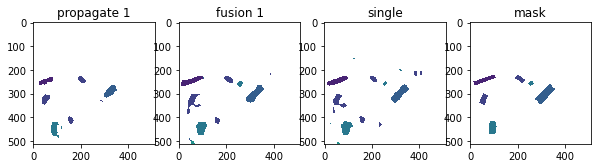

In [8]:
f = fused_mask.argmax( dim=1, keepdim=True)
l = logits_mask1.argmax( dim=1, keepdim=True)
p = propagate_mask0.argmax( dim=1, keepdim=True)
fig = plt.figure(figsize=(10, 5))

plt.subplot(1, 4, 1)
data = p[0].detach().cpu().numpy().squeeze()
data = np.ma.masked_where((0.0 == data), data) #masking the background
plt.imshow(data, vmin=0, vmax=10) # just squeeze classes dim, because we have only one class
plt.title("propagate 1")


plt.subplot(1, 4, 2)
data = f[0].detach().cpu().numpy().squeeze()
data = np.ma.masked_where((0.0 == data), data) #masking the background
plt.imshow(data, vmin=0, vmax=10) # just squeeze classes dim, because we have only one class
plt.title("fusion 1")
#plt.axis("off")

plt.subplot(1, 4, 3)
data = l[0].detach().cpu().numpy().squeeze()
data = np.ma.masked_where((0.0 == data), data) #masking the background
plt.imshow(data, vmin=0, vmax=10) # just squeeze classes dim, because we have only one class
plt.title("single")

plt.subplot(1, 4, 4)
data = batch["mask1"][0].detach().cpu().numpy().squeeze()
data = np.ma.masked_where((0.0 == data), data) #masking the background
plt.imshow(data, vmin=0, vmax=10) # just squeeze classes dim, because we have only one class
plt.title("mask")



In [9]:
fused_mask = fused_mask.permute(0,2,3,1)
logits_mask1 = logits_mask1.permute(0,2,3,1)
propagate_mask0 = propagate_mask0.permute(0,2,3,1)


In [10]:
import ipywidgets as widgets
from ipywidgets import HBox, VBox
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib notebook

<IPython.core.display.Javascript object>


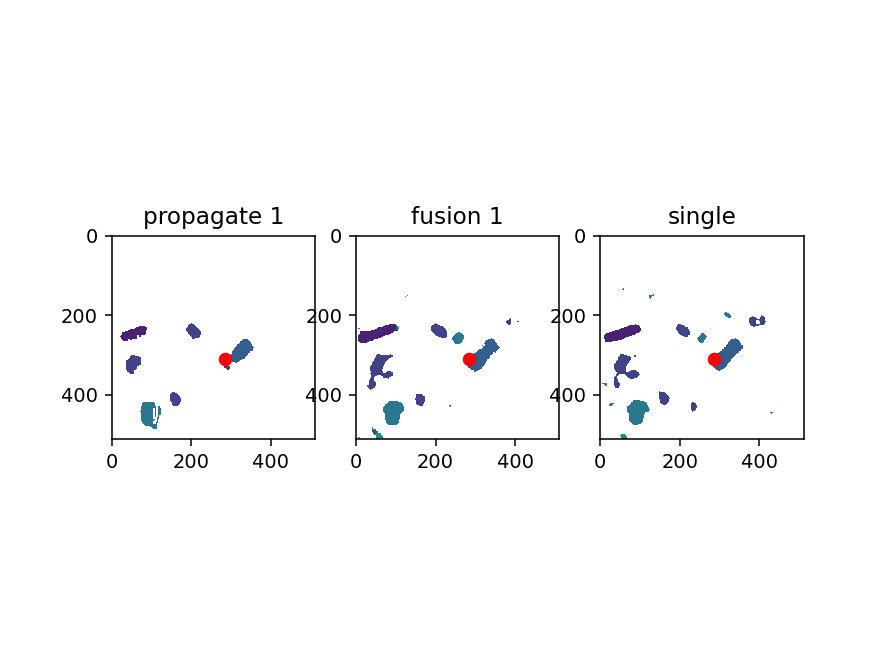

interactive(children=(IntSlider(value=1, description='x', max=511), IntSlider(value=1, description='y', max=51…

In [11]:
# set up plot
#fig, ax = plt.subplots(figsize=(10, 5))
fig, axs = plt.subplots(1, 3, sharex=True, sharey=False)

@widgets.interact(x=(0, 511, 1), y=(0, 511, 1), img_number=(0,10,1))
def update(x=1, y=1, img_number=0):
    """Remove old lines from plot and plot new one"""
    #[l.remove() for l in ax.lines]
    axs[0].clear()
    axs[1].clear()
    axs[2].clear()
    axs[0].scatter(x, y,  color='r')
    axs[1].scatter(x, y,  color='r')
    axs[2].scatter(x, y,  color='r')
    
    data = p[img_number].detach().cpu().numpy().squeeze()
    data = np.ma.masked_where((0.0 == data), data) #masking the background
    axs[0].imshow(data, vmin=0, vmax=10) # just squeeze classes dim, because we have only one class
    axs[0].set_title("propagate 1")


    plt.subplot(1, 3, 2)
    data = f[img_number].detach().cpu().numpy().squeeze()
    data = np.ma.masked_where((0.0 == data), data) #masking the background
    axs[1].imshow(data, vmin=0, vmax=10) # just squeeze classes dim, because we have only one class
    axs[1].set_title("fusion 1")
    #plt.axis("off")

    plt.subplot(1, 3, 3)
    data = l[img_number].detach().cpu().numpy().squeeze()
    data = np.ma.masked_where((0.0 == data), data) #masking the background
    axs[2].imshow(data, vmin=0, vmax=10) # just squeeze classes dim, because we have only one class
    axs[2].set_title("single")
    
    print (x, y)
    print ("single image ", logits_mask1[img_number, y, x])
    print ("propag image ", propagate_mask0[img_number, y, x])
    print ("fused  image ", fused_mask[img_number, y, x])
    
